In [ ]:
!pip3 install datasets transformers -q

In [ ]:
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import re
import numpy as np
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from dataloaders import GoEmotionsSoft

In [ ]:
go_emotions = load_dataset("go_emotions")
data = go_emotions.data

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train, valid, test = data["train"].to_pandas(), data["validation"].to_pandas(), data["test"].to_pandas()

In [ ]:
train_text = train["text"].tolist()
train_labels = train["labels"].tolist()
valid_text = valid["text"].tolist()
valid_labels = valid["labels"].tolist()
test_text = test["text"].tolist()
test_labels = test["labels"].tolist()

In [ ]:
text = train_text+valid_text+test_text
labels = train_labels+valid_labels+test_labels

In [ ]:
text = pd.DataFrame(text)
text.rename({0: 'text'}, axis=1, inplace=True)
labels= pd.DataFrame(labels)
labels.rename({0: 'emotions'}, axis=1, inplace=True)

In [ ]:
text.head()

,text
0,My favourite food is anything I didn't have to...
1,"Now if he does off himself, everyone will thin..."
2,WHY THE FUCK IS BAYLESS ISOING
3,To make her feel threatened
4,Dirty Southern Wankers


In [ ]:
labels.head()

,emotions,1,2,3,4
0,27,NaN,NaN,NaN,NaN
1,27,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN
3,14,NaN,NaN,NaN,NaN
4,3,NaN,NaN,NaN,NaN


In [ ]:
labels = labels.drop([1,2,3,4], axis=1)

In [ ]:
data = pd.concat([text, labels], axis=1)

In [ ]:
data.head()

,text,emotions
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


In [ ]:
mapping = {
    0:"admiration",
    1:"amusement",
    2:"anger",
    3:"annoyance",
    4:"approval",
    5:"caring",
    6:"confusion",
    7:"curiosity",
    8:"desire",
    9:"disappointment",
    10:"disapproval",
    11:"disgust",
    12:"embarrassment",
    13:"excitement",
    14:"fear",
    15:"gratitude",
    16:"grief",
    17:"joy",
    18:"love",
    19:"nervousness",
    20:"optimism",
    21:"pride",
    22:"realization",
    23:"relief",
    24:"remorse",
    25:"sadness",
    26:"surprise",
    27:"neutral",
}

n_labels = len(mapping)

In [ ]:
data.head()

,text,emotions
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


In [ ]:
emotions=[]
for i in data.emotions:
    emotions.append(mapping[i])
  
data['emotions']=emotions

In [ ]:
data.head()

,text,emotions
0,My favourite food is anything I didn't have to...,neutral
1,"Now if he does off himself, everyone will thin...",neutral
2,WHY THE FUCK IS BAYLESS ISOING,anger
3,To make her feel threatened,fear
4,Dirty Southern Wankers,annoyance


In [ ]:
# Balancing Neutral
# temp_df = data[data.emotions=="neutral"]
# temp_df=temp_df.sample(n = 4000)
# data= data[data.emotions!= 'neutral']
# data = pd.concat([data, temp_df])

# from sklearn.utils import shuffle
# data = shuffle(data)
# data = data.reset_index()

# data.head()

In [ ]:
# classes_ = ["admiration","amusement","anger","annoyance","approval","caring","confusion","curiosity","desire","disappointment","disapproval","disgust","embarrassment","excitement","fear","gratitude","grief","joy","love","nervousness","optimism","pride","realization","relief","remorse","sadness","surprise","neutral"]
# # classes_ = ["neutral"]
# new_list_text=[]
# new_list_emotions=[]

# for class_ in classes_:
#     temp_df = data[data.emotions==class_]
#     if(len(temp_df)>500):
#         temp_df=temp_df.sample(n = 500)
#     for i in temp_df.text:
#         new_list_text.append(i)
#     for i in temp_df.emotions:
#         new_list_emotions.append(i)

# new_df = pd.DataFrame(list(zip(new_list_text, new_list_emotions)), columns =['text', 'emotions'])  
# from sklearn.utils import shuffle
# new_df = shuffle(new_df)

# data=new_df


In [ ]:
max_len = 0
all_len=[]
for i in data.text:
    all_len.append(len(i))
    max_len=max(max_len,len(i))
print(max_len)    

514


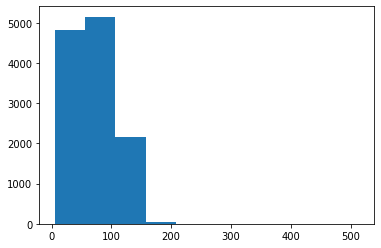

In [ ]:
from matplotlib import pyplot as plt
plt.hist(all_len)
plt.show()

In [ ]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

In [ ]:
len(data.loc[0].text.split(' '))

15

In [ ]:
len(data)

12201

In [ ]:
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 200].copy()

In [ ]:
data.head()

,text,emotions,token_size
5383,**YOU CANNOT MURDER ME! IT'S ILLEGAL.**,disapproval,6
9958,Just like that great historical fact about the...,realization,20
2704,Were lucky we were able to get this much money...,caring,20
8019,3h late comment. have fun at school !,joy,8
9107,"I'm sorry OP, every single thing on that list ...",optimism,19


In [ ]:
data['token_size'].describe()

count    12201.00000
mean        13.25629
std          6.69182
min          1.00000
25%          8.00000
50%         13.00000
75%         19.00000
max         32.00000
Name: token_size, dtype: float64

In [ ]:
inputs = ConstructVocab(data["text"].values.tolist())

In [ ]:
# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

32


In [ ]:
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [ ]:
# inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

In [ ]:
input_tensor[0:2]

[array([ 502, 1963, 3962, 3918, 3464, 3431,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 array([ 3653, 15089, 21450, 12940, 13531, 11766,  6517, 21473,  6421,
        13301,  7856, 22492, 21761, 15521,  6542, 23191, 19837, 14012,
         7012,  3110,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])]

In [ ]:
### convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [ ]:
target_tensor[0:2] 

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0]])

In [ ]:
data[0:2]

,text,emotions,token_size
5383,**YOU CANNOT MURDER ME! IT'S ILLEGAL.**,disapproval,6
9958,Just like that great historical fact about the...,realization,20


In [ ]:
get_emotion = lambda t: np.argmax(t)

In [ ]:
get_emotion(target_tensor[0])

10

In [ ]:
emotion_dict=mapping
emotion_dict[get_emotion(target_tensor[0])]

'disapproval'

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(input_tensor_train[0].dtype)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

int64


(9760, 9760, 1220, 1220, 1221, 1221)

In [ ]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = num_emotions

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
# convert the data to tensors and pass to the Dataloader 
# to create an batch iterator

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [ ]:
train_logits = torch.zeros((50000, n_labels))

train_dataset = GoEmotionsSoft(input_tensor_train, target_tensor_train, train_logits)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)

print(train_dataset)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [ ]:
val_loader.batch_size

64

In [ ]:
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden  

In [ ]:
### sort batch function to be able to use with pad_packed_sequence
def sort_batch(X, y, lengths, logits):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    logits = logits[indx]
    return X.transpose(0,1), y, lengths, logits # transpose (batch x seq) to (seq x batch)

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
# model.to(device)

# # obtain one sample from the data iterator
# it = iter(train_dataset)
# x, y, x_len, logits = next(it)

# # sort the batch first to be able to use with pac_pack sequence
# xs, ys, lens, logits = sort_batch(x, y, x_len, logits)

# print("Input size: ", xs.size())

# output, _ = model(xs.to(device), lens, device)
# print(output.size())

In [ ]:
options = {
    "epochs": 20,
    "arch": "EmoGRU",
    "k": 5,
    "gamma": 0.9,
    "t": 10
}

In [ ]:
class KL(nn.Module):
    def __init__(self, T):
        super(KL, self).__init__()
        self.T = T

    def forward(self, y_s, p_t):
        p_s = nn.functional.log_softmax(y_s/self.T, dim=1)
        loss = nn.functional.kl_div(p_s, p_t, size_average=False) * (self.T**2) / p_s.shape[0]
        return loss

    
class Temperture_Softmax(nn.Module):
    def __init__(self, T):
        super(Temperture_Softmax, self).__init__()
        self.T = T

    def forward(self, y):    
        p = nn.functional.softmax(y/self.T, dim=1)
        return p

In [ ]:
### Enabling cuda
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

### loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss

criterion_cls = nn.CrossEntropyLoss()    


criterion_soft = Temperture_Softmax(options["t"])

criterion_kl = KL(options["t"])
criterion_list = nn.ModuleList([])
criterion_list.append(criterion_cls)    # classification loss
criterion_list.append(criterion_soft)    # KL divergence loss, original knowledge distillation
criterion_list.append(criterion_kl)


optimizer = torch.optim.Adam(model.parameters())

def loss_function(y, prediction):
    """ CrossEntropyLoss expects outputs and class indices as target """
    # convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target) 
    return loss   #TODO: refer the parameter of these functions as the same
    
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

In [ ]:
def train_normal(epoch, train_loader, model, criterion, optimizer, options, train_logits):
    model.train()
    losses = AverageMeter()
    top1 = AverageMeter()
    
    if torch.cuda.is_available():
        train_logits=train_logits.cuda()
    
    for idx, (image, labels, lens, softlabel, index) in enumerate(train_loader):
        if torch.cuda.is_available():
            image = image.cuda()
            labels = labels.cuda()
        output, _ = model(image.permute(1 ,0).to(device), lens, device)
        train_logits[index] = output
        loss = criterion(output, labels.argmax(dim=1))
        acc1 = accuracy(output, labels)
        losses.update(loss.item(), image.size(0))
        top1.update(acc1.item(), image.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return top1.avg, losses.avg, train_logits




def train_lwr(epoch, train_loader, model, criterion_list, optimizer, options, train_logits):
    model.train()
    if torch.cuda.is_available():
        train_logits=train_logits.cuda()

    criterion_cls = criterion_list[0]
    critetion_soft = criterion_list[1]
    criterion_kl = criterion_list[2]

    losses = AverageMeter()
    top1 = AverageMeter()

    
    for idx, data in enumerate(train_loader):
        image, labels, lens, logits, index = data
        if torch.cuda.is_available():
            image = image.cuda().int()
            labels = labels.cuda()
            logits = logits.cuda()
        
        soft_label = critetion_soft(logits)        
        preact = False
        logit_s, _ = model(image.permute(1 ,0).to(device), lens, device)
        train_logits[index] = logit_s
        loss_cls = criterion_cls(logit_s, labels.argmax(dim=1))        
        loss_kl = criterion_kl(logit_s, soft_label)

        if epoch<=options["k"]:
            loss = loss_cls 
        else:
            num_5 = int(epoch/options["k"])
            cure = num_5*options["k"]
            
            loss = (options["gamma"]+(1-cure/240)*(1-options["gamma"])) * loss_cls + cure/240*(1-options["gamma"])* loss_kl

        acc1 = accuracy(logit_s, labels)
        losses.update(loss.item(), image.size(0))
        top1.update(acc1.item(), image.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return top1.avg, losses.avg, train_logits

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def validate(val_loader, model, criterion, options):
    
    losses = AverageMeter()
    top1 = AverageMeter()

    model.eval()

    with torch.no_grad():
        
        for idx, (image, label, lens) in enumerate(val_loader):

            if torch.cuda.is_available():
                image = image.cuda()
                labels = label.cuda()

            output, _ = model(image.permute(1 ,0).to(device), lens, device)
            loss = criterion(output, labels.argmax(dim=1))
            acc1 = accuracy(output, labels)
            losses.update(loss.item(), image.size(0))
            top1.update(acc1.item(), image.size(0))
            
    return top1.avg,losses.avg


# Cross Entropy

In [ ]:
# No LWR

train_accs = []
train_losses = []
test_accs = []
test_losses = []

best_acc = 0
for epoch in range(1, int(options["epochs"])+ 1):

        train_acc, train_loss, train_logits= train_normal(epoch, train_loader, model, criterion, optimizer, options, train_logits)
         
        
        train_logits = train_logits.detach().cpu()
            
        if epoch>=options["k"] and epoch%options["k"]==0:
            print('label update')
            train_dataset = GoEmotionsSoft(input_tensor_train, target_tensor_train, train_logits)
            train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                                drop_last=True,
                                shuffle=True)
        
        print('epoch {}'.format(epoch))


        test_acc, test_loss = validate(val_loader, model, criterion, options)

        train_accs.append(train_acc)
        train_losses.append(train_loss)
        test_accs.append(test_acc)
        test_losses.append(test_loss)

        print("Current Test Accuracy:",test_acc)
        # calculate best accuracy.
        if test_acc > best_acc:
            best_acc = test_acc
        
        print('best accuracy:', best_acc)


epoch 1
Current Test Accuracy: 17.1875
best accuracy: 17.1875
epoch 2
Current Test Accuracy: 26.644736842105264
best accuracy: 26.644736842105264
epoch 3
Current Test Accuracy: 32.31907894736842
best accuracy: 32.31907894736842
epoch 4
Current Test Accuracy: 31.825657894736842
best accuracy: 32.31907894736842
label update
epoch 5
Current Test Accuracy: 33.223684210526315
best accuracy: 33.223684210526315
epoch 6
Current Test Accuracy: 32.64802631578947
best accuracy: 33.223684210526315
epoch 7
Current Test Accuracy: 31.49671052631579
best accuracy: 33.223684210526315
epoch 8
Current Test Accuracy: 32.483552631578945
best accuracy: 33.223684210526315
epoch 9
Current Test Accuracy: 32.483552631578945
best accuracy: 33.223684210526315
label update
epoch 10
Current Test Accuracy: 32.07236842105263
best accuracy: 33.223684210526315
epoch 11
Current Test Accuracy: 32.97697368421053
best accuracy: 33.223684210526315
epoch 12
Current Test Accuracy: 32.483552631578945
best accuracy: 33.22368421

In [ ]:
print('train_accs', train_accs)
print('train_losses', train_losses)
print('test_accs', test_accs)
print('test_losses', test_losses)

train_accs [7.401315789473684, 22.388980263157894, 36.99629934210526, 56.79481907894737, 79.40995065789474, 93.95559210526316, 98.64309210526316, 99.50657894736842, 99.56825657894737, 99.84580592105263, 99.8560855263158, 99.84580592105263, 99.71217105263158, 97.2142269736842, 95.81620065789474, 96.90583881578948, 98.84868421052632, 99.52713815789474, 99.79440789473684, 99.83552631578948]
train_losses [3.308110808071337, 2.795222188297071, 2.242345962085222, 1.531380002435885, 0.7411575654619619, 0.24430109295797975, 0.0705337007652576, 0.029007248562074414, 0.01917666633686933, 0.009312698518011817, 0.0063396349574567894, 0.005852820121569829, 0.009790631351949597, 0.1024596614481293, 0.13930709298553043, 0.10121724894270301, 0.0457938908795385, 0.019400301593888895, 0.011173910808314471, 0.008160562620201074]
test_accs [17.1875, 26.644736842105264, 32.31907894736842, 31.825657894736842, 33.223684210526315, 32.64802631578947, 31.49671052631579, 32.483552631578945, 32.483552631578945, 3

## Validation

In [ ]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

device = "cuda" # we don't need GPU to do testing
model.to(device)
# model.to("cpu")

for (batch, (inp, targ, lens)) in enumerate(test_loader):          
    predictions,_ = model(inp.permute(1, 0).to(device), lens, device)  
    batch_loss = criterion(predictions, targ.to(device).argmax(dim=1))     
    batch_accuracy = accuracy(targ.to(device), predictions)
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy.cpu().detach().numpy() / TEST_N_BATCH)
print("Test Loss: ", batch_loss.cpu().detach().numpy())

Test Accuracy:  29.605263157894736
Test Loss:  4.741197


# LWR

In [ ]:
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

train_accs = []
train_losses = []
test_accs = []
test_losses = []

best_acc = 0
for epoch in range(1, int(options["epochs"])+ 1):

        if epoch<=options["k"]:
            train_acc, train_loss, train_logits= train_normal(epoch, train_loader, model, criterion, optimizer, options, train_logits)
        else:
            train_acc, train_loss, train_logits= train_lwr(epoch, train_loader, model, criterion_list, optimizer, options, train_logits)
         
        
        train_logits = train_logits.detach().cpu()
            
        if epoch>=options["k"] and epoch%options["k"]==0:
            print('label update')
            train_dataset = GoEmotionsSoft(input_tensor_train, target_tensor_train, train_logits)
            train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                                drop_last=True,
                                shuffle=True)
        
        print('epoch {}'.format(epoch))


        test_acc, test_loss = validate(val_loader, model, criterion, options)

        print("Current Test Accuracy:",test_acc)
        # calculate best accuracy.
        if test_acc > best_acc:
            best_acc = test_acc
        
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        test_accs.append(test_acc)
        test_losses.append(test_loss)

        print('best accuracy:', best_acc)


epoch 1
Current Test Accuracy: 16.69407894736842
best accuracy: 16.69407894736842
epoch 2
Current Test Accuracy: 26.23355263157895
best accuracy: 26.23355263157895
epoch 3
Current Test Accuracy: 32.89473684210526
best accuracy: 32.89473684210526
epoch 4
Current Test Accuracy: 33.223684210526315
best accuracy: 33.223684210526315
label update
epoch 5
Current Test Accuracy: 33.79934210526316
best accuracy: 33.79934210526316


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch 6
Current Test Accuracy: 31.661184210526315
best accuracy: 33.79934210526316
epoch 7
Current Test Accuracy: 33.4703947368421
best accuracy: 33.79934210526316
epoch 8
Current Test Accuracy: 32.31907894736842
best accuracy: 33.79934210526316
epoch 9
Current Test Accuracy: 32.89473684210526
best accuracy: 33.79934210526316
label update
epoch 10
Current Test Accuracy: 32.89473684210526
best accuracy: 33.79934210526316
epoch 11
Current Test Accuracy: 32.64802631578947
best accuracy: 33.79934210526316
epoch 12
Current Test Accuracy: 32.401315789473685
best accuracy: 33.79934210526316
epoch 13
Current Test Accuracy: 32.483552631578945
best accuracy: 33.79934210526316
epoch 14
Current Test Accuracy: 32.23684210526316
best accuracy: 33.79934210526316
label update
epoch 15
Current Test Accuracy: 32.64802631578947
best accuracy: 33.79934210526316
epoch 16
Current Test Accuracy: 32.1546052631579
best accuracy: 33.79934210526316
epoch 17
Current Test Accuracy: 32.64802631578947
best accuracy:

In [ ]:
print('train_accs', train_accs)
print('train_losses', train_losses)
print('test_accs', test_accs)
print('test_losses', test_losses)

train_accs [7.401315789473684, 23.76644736842105, 39.514802631578945, 57.874177631578945, 81.1986019736842, 94.84991776315789, 98.8795230263158, 99.58881578947368, 99.7532894736842, 99.8046875, 99.83552631578948, 99.82524671052632, 99.83552631578948, 99.84580592105263, 99.83552631578948, 99.81496710526316, 99.83552631578948, 99.83552631578948, 99.88692434210526, 99.82524671052632]
train_losses [3.3012539524781075, 2.7552304330625033, 2.1769121704917205, 1.4740154182440357, 0.6921032141698035, 0.22104367054998875, 0.06853497306522179, 0.030780487173040837, 0.020781625184769694, 0.021964396944416587, 0.011201130860411612, 0.010360863387560178, 0.010762636534453026, 0.009912819338129148, 0.011479401826172284, 0.010325777984689921, 0.009434673086568517, 0.0104717093146112, 0.009189858401537333, 0.012670014770456442]
test_accs [16.69407894736842, 26.23355263157895, 32.89473684210526, 33.223684210526315, 33.79934210526316, 31.661184210526315, 33.4703947368421, 32.31907894736842, 32.894736842

## Validation

In [ ]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

device = "cuda" # we don't need GPU to do testing
model.to(device)
# model.to("cpu")

for (batch, (inp, targ, lens)) in enumerate(test_loader):          
    predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
    batch_accuracy = accuracy(targ.to(device), predictions)
    batch_loss = criterion(predictions, targ.to(device).argmax(dim=1))
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy.cpu().detach().numpy() / TEST_N_BATCH)
print("Test Loss: ", batch_loss.cpu().detach().numpy())

Test Accuracy:  30.345394736842106
Test Loss:  5.0970454


In [ ]:
model.parameters

<bound method Module.parameters of EmoGRU(
  (embedding): Embedding(23873, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (gru): GRU(256, 1024)
  (fc): Linear(in_features=1024, out_features=28, bias=True)
)>

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
# model.load_state_dict(torch.load("/content/model.pth"))
# model.eval()

In [ ]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

device = "cuda" # we don't need GPU to do testing
model.to(device)
# model.to("cpu")

for (batch, (inp, targ, lens)) in enumerate(test_loader):          
    predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
    batch_accuracy = accuracy(targ.to(device), predictions)
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy.cpu().detach().numpy() / TEST_N_BATCH)

Test Accuracy:  30.18092105263158


In [ ]:
torch.save(model.state_dict(), "/content/model.pth")